### Load Python Pakages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [2]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

#preprocessing

#feature engineering
from sklearn.feature_selection import mutual_info_classif


#algorithms
from xgboost import XGBClassifier
import xgboost as xgb

#model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

#!pip3 install yellowbrick
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, DiscriminationThreshold

#!pip3 install shap
import shap

from ipywidgets import interact, FloatSlider

random_state = 42

In [3]:
#preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder,OneHotEncoder, OrdinalEncoder

#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import set_config

#algorithms
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.base import clone
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.linear_model import LogisticRegression


#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import make_scorer, RocCurveDisplay, confusion_matrix

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

### Lets look into data

In [4]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv', index_col=[0])
#original_df = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv', index_col=[0])

train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [5]:
print(train_df.shape)
print(test_df.shape)

(11504798, 11)
(7669866, 10)


In [6]:
#This function reduces memory usage. Reference: https://www.kaggle.com/code/jmascacibar/optimizing-memory-usage-with-insurance-cross-sell/notebook
def shrink_and_dummify(df):
    df["Vehicle_Age"] = df["Vehicle_Age"].apply(lambda x: 0 if x == '< 1 Year' else (1 if x == '1-2 Year' else 2)).astype('int8')
    df['Gender'] = df['Gender'].apply(lambda x: 0 if x == 'Female' else 1).astype('int8')
    df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 0 if x == 'No' else 1).astype('int8')
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')
    
    if 'Response' in df.columns:
        df['Response'] = df['Response'].astype('int8')
    
    return df

In [7]:
train_df = shrink_and_dummify(train_df)
test_df = shrink_and_dummify(test_df)

### Descpriptive statistics

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,11504798.0,0.541351,0.498287,0.0,0.0,1.0,1.0,1.0
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Region_Code,11504798.0,26.418690,12.991590,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Vehicle_Age,11504798.0,0.603107,0.567856,0.0,0.0,1.0,1.0,2.0
Vehicle_Damage,11504798.0,0.502680,0.499993,0.0,0.0,1.0,1.0,1.0
Annual_Premium,11504798.0,30461.370411,16454.745205,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0


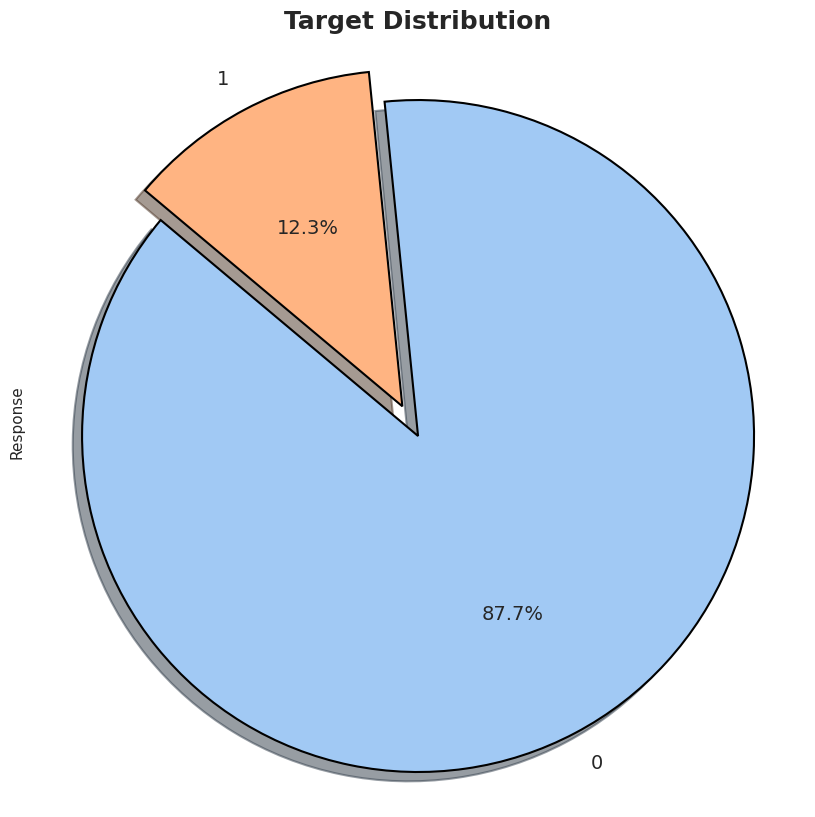

In [9]:
plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.05 for _ in range(train_df['Response'].nunique())]

# Plotting
train_df.groupby('Response')['Response'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

### Grouping features for preprocessing purposes

In [10]:
train_df.nunique().sort_values()

Gender                      2
Driving_License             2
Vehicle_Damage              2
Previously_Insured          2
Response                    2
Vehicle_Age                 3
Region_Code                53
Age                        66
Policy_Sales_Channel      152
Vintage                   290
Annual_Premium          51728
dtype: int64

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype
---  ------                -----
 0   Gender                int8 
 1   Age                   int8 
 2   Driving_License       int8 
 3   Region_Code           int8 
 4   Previously_Insured    int8 
 5   Vehicle_Age           int8 
 6   Vehicle_Damage        int8 
 7   Annual_Premium        int32
 8   Policy_Sales_Channel  int16
 9   Vintage               int16
 10  Response              int8 
dtypes: int16(2), int32(1), int8(8)
memory usage: 263.3 MB


In [12]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Response"]

target = "Response"

binary_features = ['Previously_Insured','Driving_License', 'Gender', 'Vehicle_Damage', 'Vehicle_Age']

continuous_features = list(set(feature_list) - set(binary_features))

assert feature_list.sort() == (continuous_features + binary_features).sort()

### Exploratory Data Analysis

In [13]:
#Data is huge just take some sample for eda
eda_df = train_df.sample(frac=0.01)

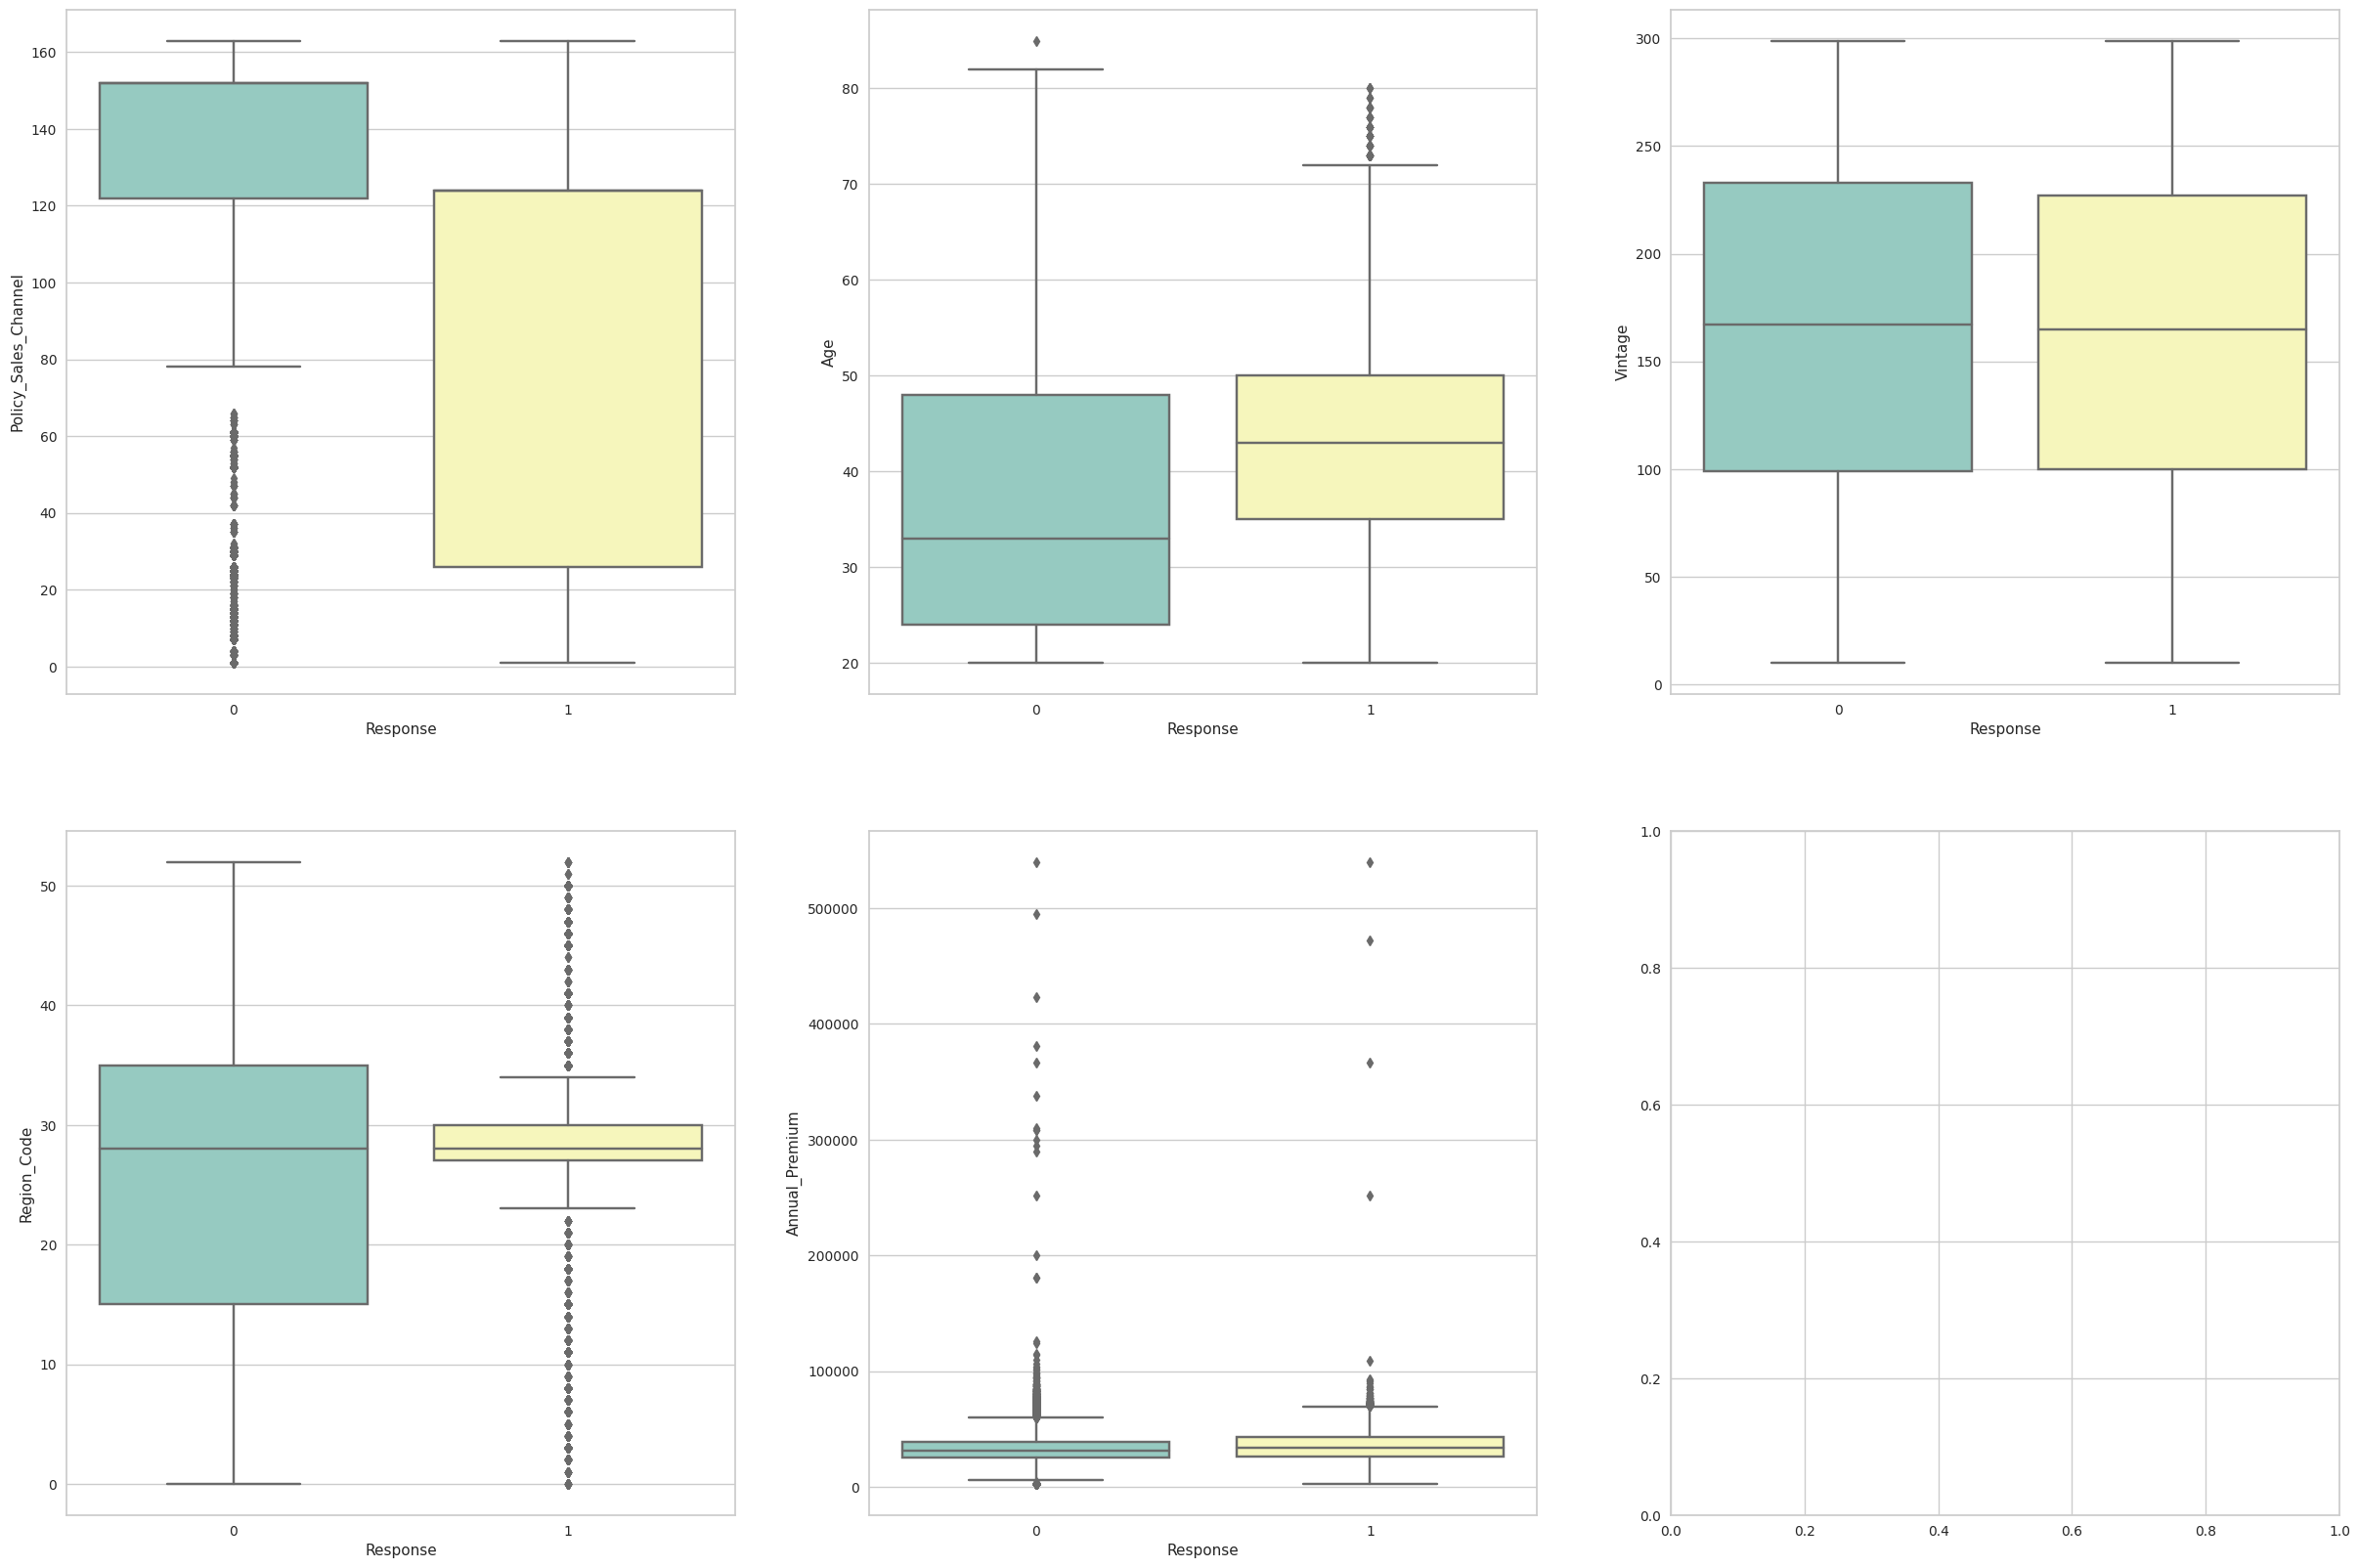

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Response', y=var, data=eda_df, ax=subplot, palette='Set3')

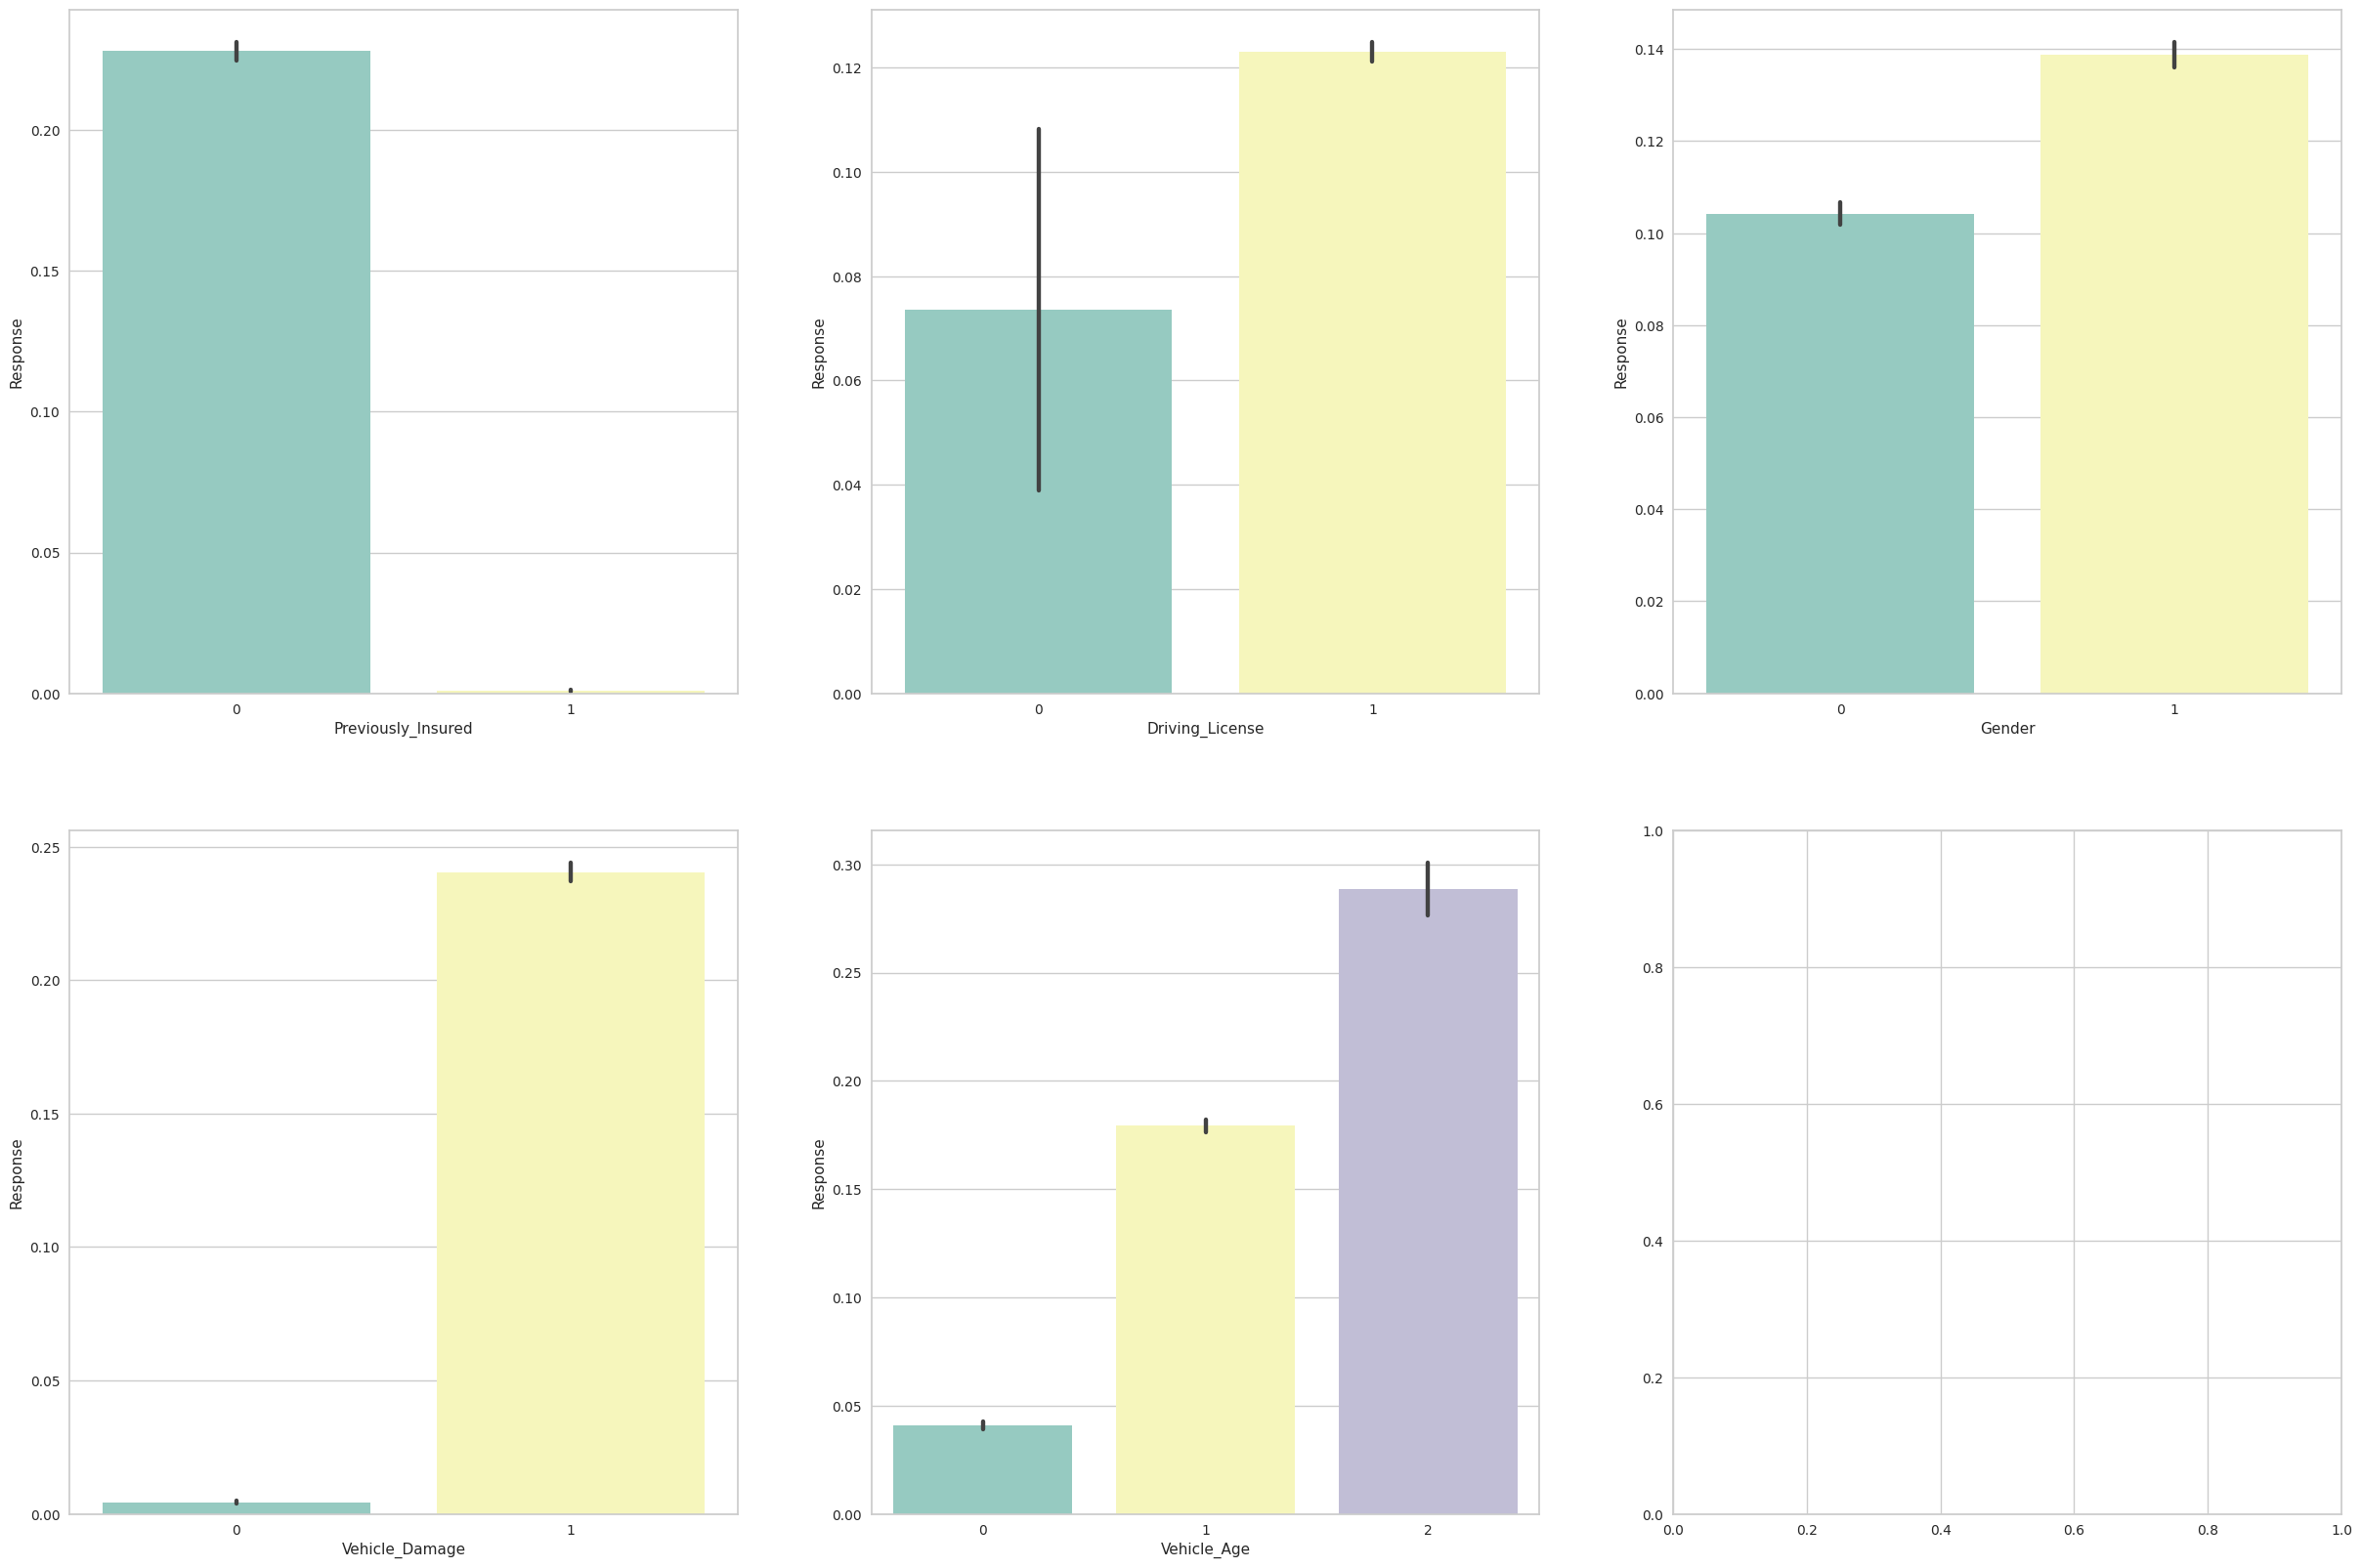

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
for var, subplot in zip(binary_features, ax.flatten()):
    sns.barplot(x= var, y= 'Response', data=eda_df, ax=subplot, palette='Set3')

### Feature Engineering

In [16]:
# determine the mutual information for features

mutual_df = eda_df[feature_list]
y_sampled = eda_df.Response
mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
Previously_Insured,0.093797
Vehicle_Damage,0.090895
Age,0.037548
Vehicle_Age,0.033476
Policy_Sales_Channel,0.025490
Driving_License,0.020431
Gender,0.012082
Region_Code,0.011557
Annual_Premium,0.008493
Vintage,0.006412


In [17]:
#eda_df = pd.get_dummies(eda_df, columns=['Previously_Insured'])
#eda_df['Previously_Insured_Yes'] = eda_df['Previously_Insured_Yes'].astype('int')
#eda_df['Previously_Insured_No'] = eda_df['Previously_Insured_No'].astype('int')
#eda_df.head().T

In [18]:
#eda_df = eda_df.rename(columns={'Vehicle_Age_1-2 Year': 'Vehicle_Age_1-2_Year', 'Vehicle_Age_< 1 Year': 'Vehicle_Age_less_than_1_Year',
#                                'Vehicle_Age_> 2 Years': 'Vehicle_Age_greater_than_2_Years'})
#eda_df.head().T

In [19]:
#eda_df['Vehicle_Age'] = eda_df['Vehicle_Age'].apply(lambda x: '1-2_Year' if x == '1-2 Year' else ('less_than_1_Year' 
#                                                                  if x == '< 1 Year' else ('greater_than_2_Years')))
#eda_df.head().T

In [20]:
#eda_df = pd.get_dummies(eda_df, columns=['Vehicle_Age'])
#eda_df['Vehicle_Age_less_than_1_Year'] = eda_df['Vehicle_Age_less_than_1_Year'].astype('int')
#eda_df['Vehicle_Age_1-2_Year'] = eda_df['Vehicle_Age_1-2_Year'].astype('int')
#eda_df['Vehicle_Age_greater_than_2_Years'] = eda_df['Vehicle_Age_greater_than_2_Years'].astype('int')
#eda_df.head().T

In [21]:
#eda_df = pd.get_dummies(eda_df, columns=['Gender'])
#eda_df['Gender_Male'] = eda_df['Gender_Male'].astype('int')
#eda_df['Gender_Female'] = eda_df['Gender_Female'].astype('int')
#eda_df.head().T

In [22]:
#eda_df = pd.get_dummies(eda_df, columns=['Vehicle_Damage'])
#eda_df['Vehicle_Damage_Yes'] = eda_df['Vehicle_Damage_Yes'].astype('int')
#eda_df['Vehicle_Damage_No'] = eda_df['Vehicle_Damage_No'].astype('int')
#eda_df.head().T

### Modeling and hyperparameter tuning

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
#A cross-validation function with early stopping. I used some crowdy code  to get the best iterations. If you have more elegant suggestions, please put the comment.

def cross_validate_score(model, data: pd.DataFrame, cv=None, test_data: pd.DataFrame = None, label: str = 'Response', include_original: bool = True, original_data: pd.DataFrame = None):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    if test_data is None:
        raise ValueError("test_data must be provided")
    
    X = data.copy()
    y = X.pop(label)
    
    val_predictions = np.zeros(len(X))
    test_predictions = np.zeros(len(test_data))
    train_scores, val_scores = [], []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        X_val = X.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        if include_original:
            if original_data is None:
                raise ValueError("original_data must be provided when include_original is True")
            X_train = pd.concat([original_data.drop(label, axis=1), X_train]).reset_index(drop=True)
            y_train = pd.concat([original_data[label], y_train]).reset_index(drop=True)
        
        model_cloned = clone(model)
        
        if isinstance(model_cloned, XGBClassifier):
            eval_set = [(X_val, y_val)]
            model_cloned.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=50, verbose=False)
            best_iteration = model_cloned.best_iteration
            train_preds_proba = model_cloned.predict_proba(X_train, iteration_range=(0, best_iteration))[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val, iteration_range=(0, best_iteration))[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data, iteration_range=(0, best_iteration))[:, 1]
        elif isinstance(model_cloned, LGBMClassifier):
            eval_set = [(X_val, y_val)]
            model_cloned.fit(X_train, y_train, eval_set=eval_set, eval_metric='auc', callbacks=[early_stopping(50)])
            best_iteration = model_cloned.best_iteration_
            train_preds_proba = model_cloned.predict_proba(X_train, num_iteration=best_iteration)[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val, num_iteration=best_iteration)[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data, num_iteration=best_iteration)[:, 1]
        elif isinstance(model_cloned, CatBoostClassifier):
            model_cloned.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
            best_iteration = model_cloned.get_best_iteration()
            train_preds_proba = model_cloned.predict_proba(X_train)[:, 1]
            val_preds_proba = model_cloned.predict_proba(X_val)[:, 1]
            test_preds_proba = model_cloned.predict_proba(test_data)[:, 1]
        else:
            raise ValueError("Model type not supported for early stopping.")
        
        val_predictions[val_idx] = val_preds_proba
        train_scores.append(roc_auc_score(y_train, train_preds_proba))
        val_scores.append(roc_auc_score(y_val, val_preds_proba))
        
        print(f'Fold {fold}: {val_scores[-1]:.5f}')
        
        test_predictions += test_preds_proba / cv.get_n_splits()
        
    print(f'Val Score: {np.mean(val_scores):.7f} ± {np.std(val_scores):.7f} | Train Score: {np.mean(train_scores):.7f} ± {np.std(train_scores):.7f} | {label}')
    
    return val_scores, val_predictions, test_predictions

In [25]:
cv_summary, oof_predictions, test_predictions = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

### XGBoost

In [26]:
xgb_params = {
    
    'n_estimators': 10000,
    'eta': 0.05,
    'alpha':  0.2545607592482198,
    'subsample': 0.8388163485383147, 
    'colsample_bytree': 0.2732499701466825, 
    'max_depth': 16,
    'min_child_weight': 5,
    'gamma': 0.0017688666476104672,
    'eval_metric': 'auc',
    'max_bin': 262143, #a weird max_bin, for reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516265   
    'tree_method': 'gpu_hist',
}

xgb_tuned = XGBClassifier(**xgb_params, random_state=random_state)

In [27]:
%%time
cv_summary['xgb'], oof_predictions['xgb'], test_predictions['xgb'] = cross_validate_score(xgb_tuned, data=train_df, test_data=test_df, include_original=False)

Fold 0: 0.89162
Fold 1: 0.89134
Fold 2: 0.89152
Fold 3: 0.89140
Fold 4: 0.89144
Val Score: 0.8914623 ± 0.0000980 | Train Score: 0.9020916 ± 0.0009083 | Response
CPU times: user 1h 1min 5s, sys: 21.3 s, total: 1h 1min 26s
Wall time: 59min 50s


### CatBoost

In [28]:
catb_params = {
    'iterations': 10000,
    'eval_metric': 'AUC',
    'task_type': 'GPU',
    'learning_rate': 0.1,
    'depth': 9,
    'l2_leaf_reg': 55.37964307854247,
    'max_bin': 404,
    'bagging_temperature': 0.017138393608280057,
    'random_strength': 9.256288011643901
}


#defining all features as cateegorical makes huge impact 
#reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
catb_tuned = CatBoostClassifier(**catb_params, random_state=random_state, logging_level='Silent',cat_features=test_df.columns.values)

In [29]:
%%time
cv_summary['catb'], oof_predictions['catb'], test_predictions['catb'] = cross_validate_score(catb_tuned, data=train_df, test_data=test_df, include_original=False)

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 0: 0.89518


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1: 0.89475


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2: 0.89507


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3: 0.89488


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4: 0.89557
Val Score: 0.8950899 ± 0.0002826 | Train Score: 0.9335113 ± 0.0007298 | Response
CPU times: user 3h 28min 20s, sys: 8min 13s, total: 3h 36min 34s
Wall time: 2h 43min 7s


### Performance Summary

In [30]:
#performance summary for base learners
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold1','fold2','fold3','fold4','fold5']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

,fold1,fold2,fold3,fold4,fold5,Mean,Std
catb,0.895178,0.894749,0.895070,0.894881,0.895571,0.895090,0.000283
xgb,0.891617,0.891337,0.891521,0.891398,0.891439,0.891462,0.000098


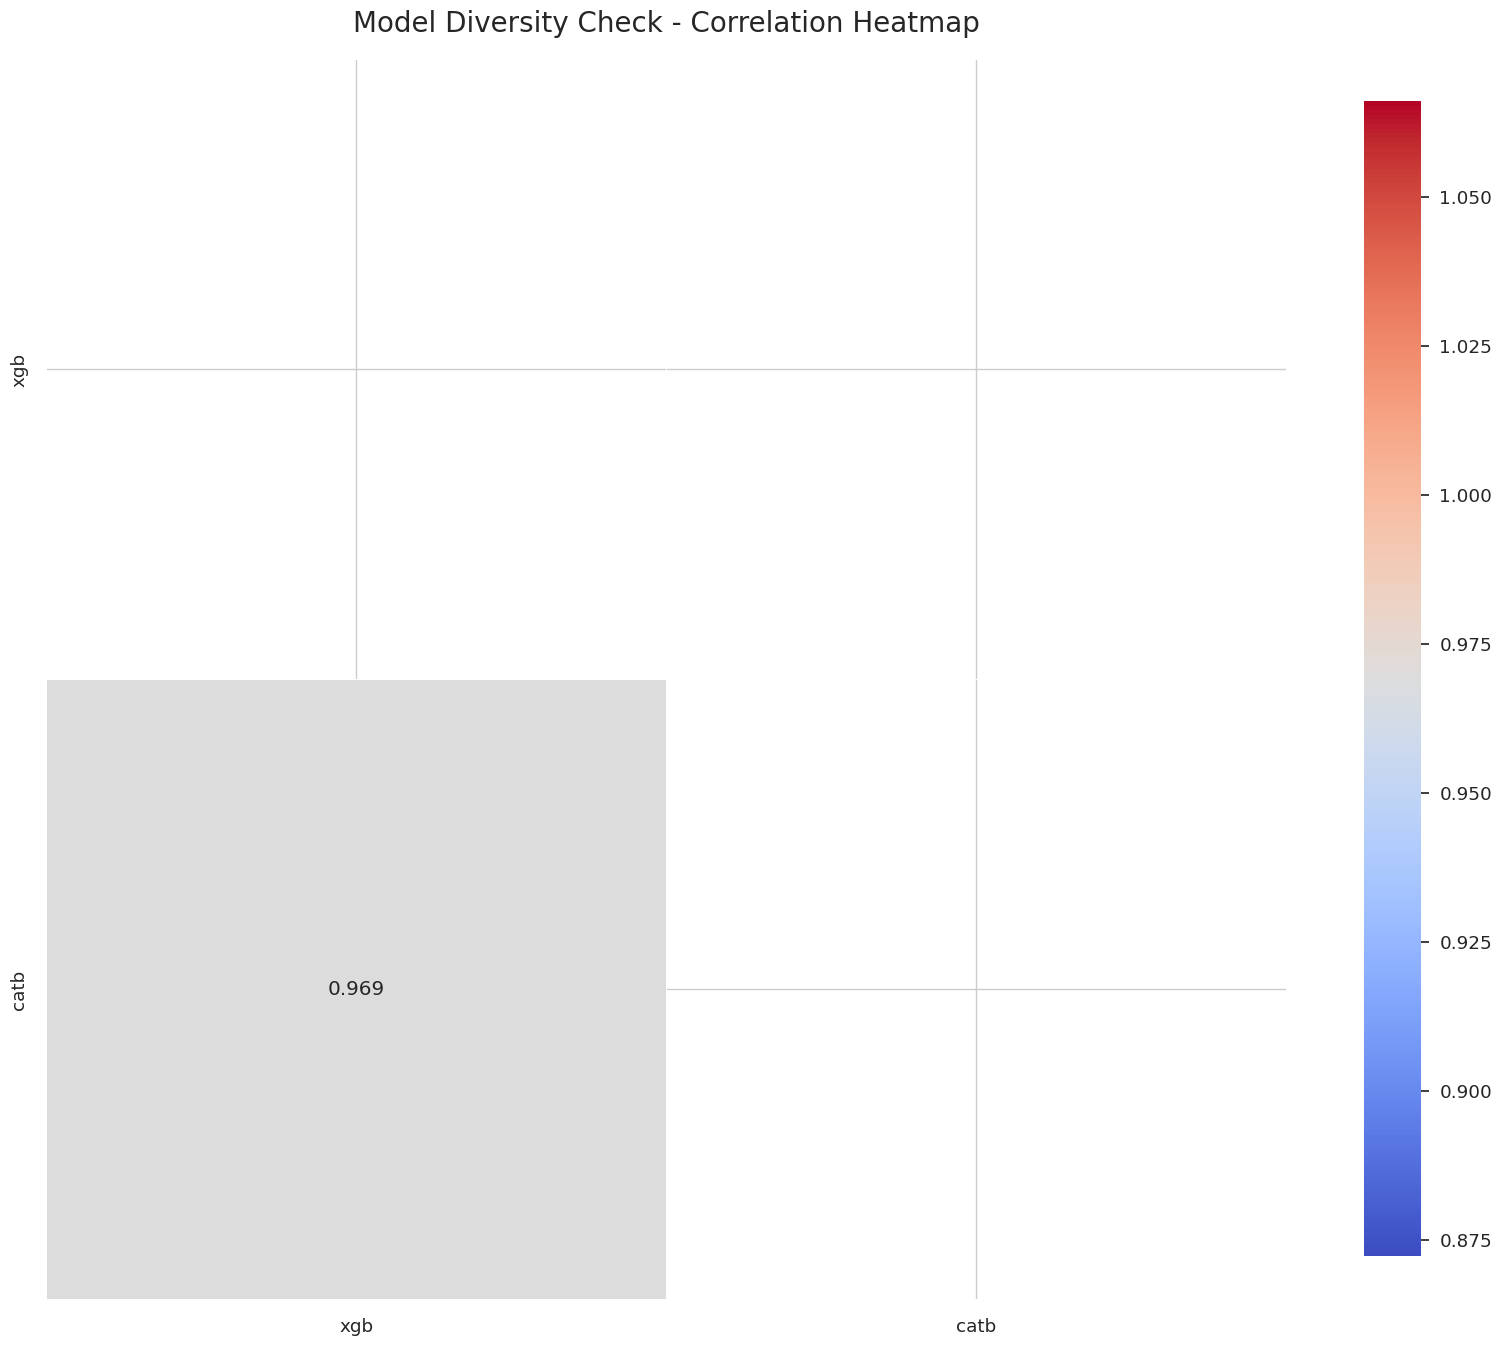

In [31]:
sns.set(font_scale=1.2, style="whitegrid")
correlation_train = oof_predictions.corr()
mask = np.triu(np.ones_like(correlation_train, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train, 
            mask=mask, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .75})
plt.title('Model Diversity Check - Correlation Heatmap', fontsize=20, pad=20)
plt.show()

### Voting vs Stacking

In [32]:
#probability averaging
def soft_voting_ensemble(oof_df, y_actual):

    mean_prob = oof_df.mean(axis=1)
    ensemble_auc = roc_auc_score(y_actual, mean_prob)
    print(f'Ensemble AUC: {ensemble_auc:.5f}')
    
    return mean_prob, ensemble_auc

In [33]:
_ , ensemble_auc = soft_voting_ensemble(oof_predictions, train_df.Response)

Ensemble AUC: 0.89492


In [34]:
#parameters suggested for meta model                                                                                                 
meta_model_params = {
'n_estimators': 43, 'alpha': 0.000759453839369262, 'subsample': 0.8635904939859487, 'colsample_bytree': 0.7579443772400538,
    'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.13688008280542863, 'gamma': 0.19965095682630274}

meta_model = XGBClassifier(**meta_model_params, random_state=random_state)

In [35]:
#%%time

#Deciding which models to include ensemble
#from sklearn.feature_selection import RFECV

min_features_to_select = 1

# Create a pipeline with preprocessor, RFECV, and LGBMClassifier
#pipeline = Pipeline([
#    ('rfecv', RFECV(estimator=meta_model,
#                    step=1,
#                    cv=cv,
#                    scoring="roc_auc",
#                    min_features_to_select=min_features_to_select,
#                    n_jobs=-1,))
#])

# Fit the pipeline on the training data
#pipeline.fit(oof_predictions, train_df.Response)

#CV score
#print("Best CV score: ")
#selected_models = np.array( oof_predictions.columns)[pipeline.named_steps['rfecv'].support_]
#print( pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_models) - 1])



# Selected features after RFECV
#print('Number of evaluated models:', len(oof_predictions.columns))
#print('Number of selected models for ensemble:', len(selected_models))
#print("Selected models:", selected_models)

In [36]:
#above code selects following models:
selected_models = ['xgb', 'catb']

### Submission

In [37]:
meta_model = meta_model.fit(oof_predictions[selected_models], train_df.Response)

In [38]:
preds_test =  meta_model.predict_proba(test_predictions[selected_models])[:, 1]

In [39]:
output = pd.DataFrame({'id': test_df.index,
                       'Response': preds_test})

In [40]:
output.to_parquet('submission.parquet', index=False)

In [41]:
oof_predictions.to_parquet('oof_predictions.parquet', index=False)
test_predictions.to_parquet('test_predictions.parquet', index=False)